<a href="https://www.kaggle.com/code/mastersniffer/videogames-with-automl-rf-lg-randomsearchcv?scriptVersionId=137251112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Thanks to IGNACIO CHAVARRIA for such guide. I've updated it a bit more and added few features which you might like

In [1]:
#!pip install auto-sklearn -q
!pip install h2o -q
!pip install PipelineProfiler -q

In [2]:
import pandas as pd
from pandas import get_dummies

import gc

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from datetime import datetime
from pandas import Series
from math import ceil

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,mean_absolute_error, roc_auc_score
from sklearn import svm

import warnings
warnings.filterwarnings("ignore")

# import autosklearn
# from autosklearn.classification import AutoSklearnClassifier
# from autosklearn.regression import AutoSklearnRegressor

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/video-game-sales-with-ratings/Video_Games_Sales_as_at_22_Dec_2016.csv', encoding="utf-8")
dfa = df.copy()
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Top values in the dataset
---
**By platform, developer, publisher and genre.**

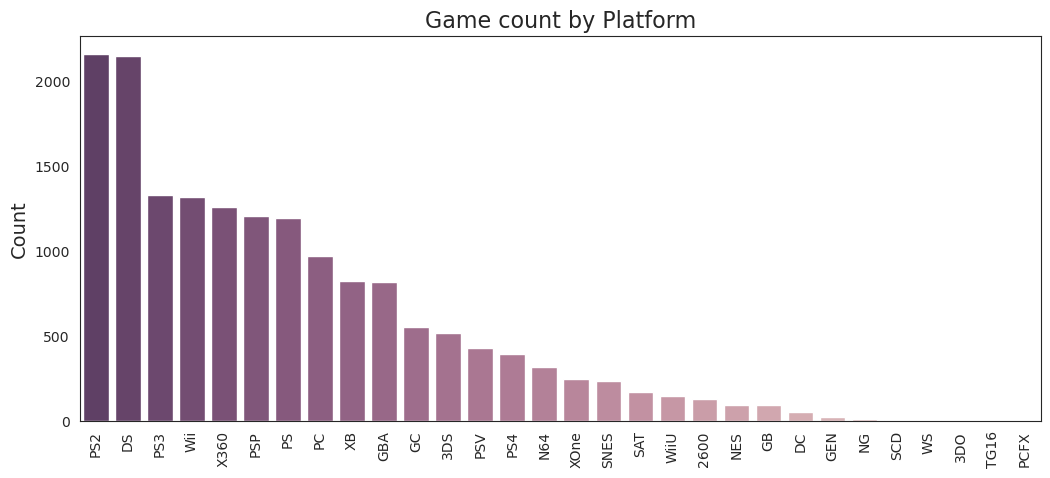

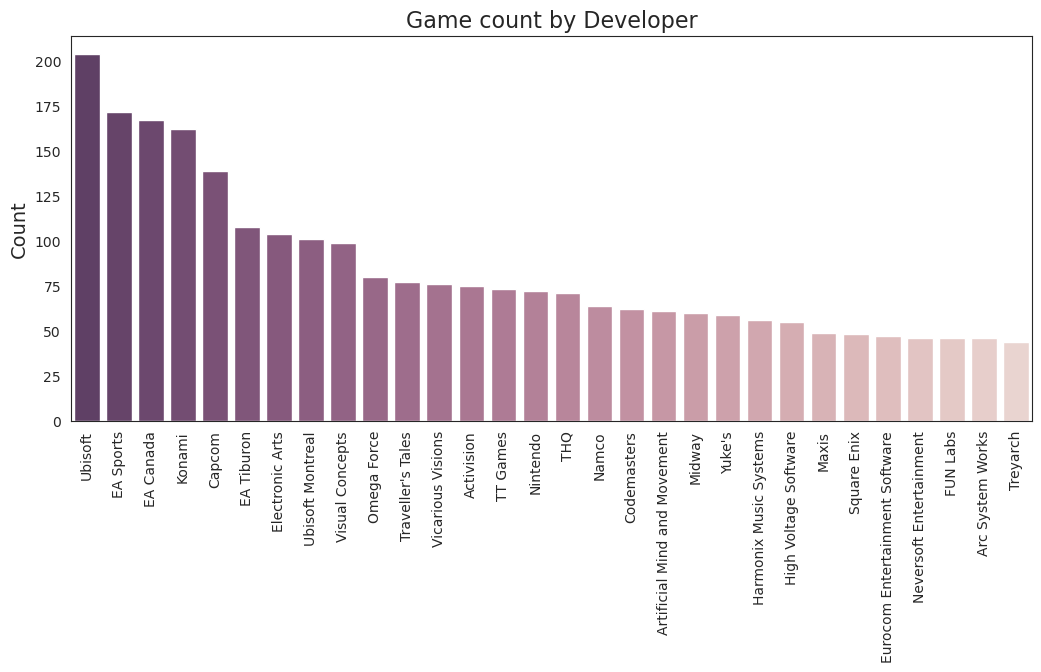

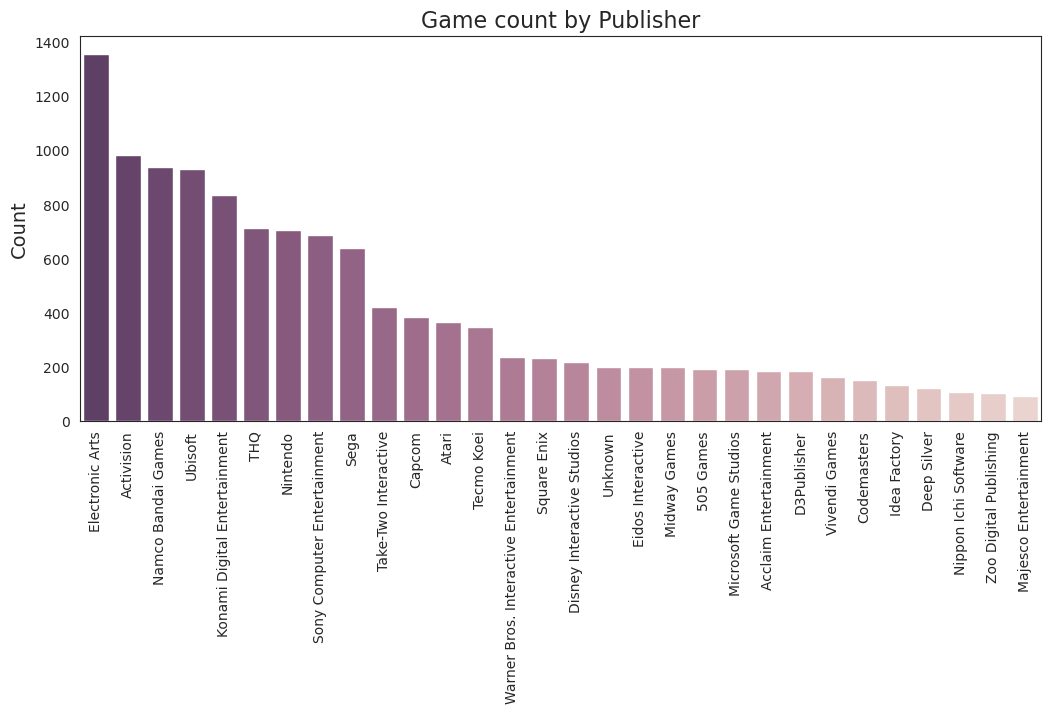

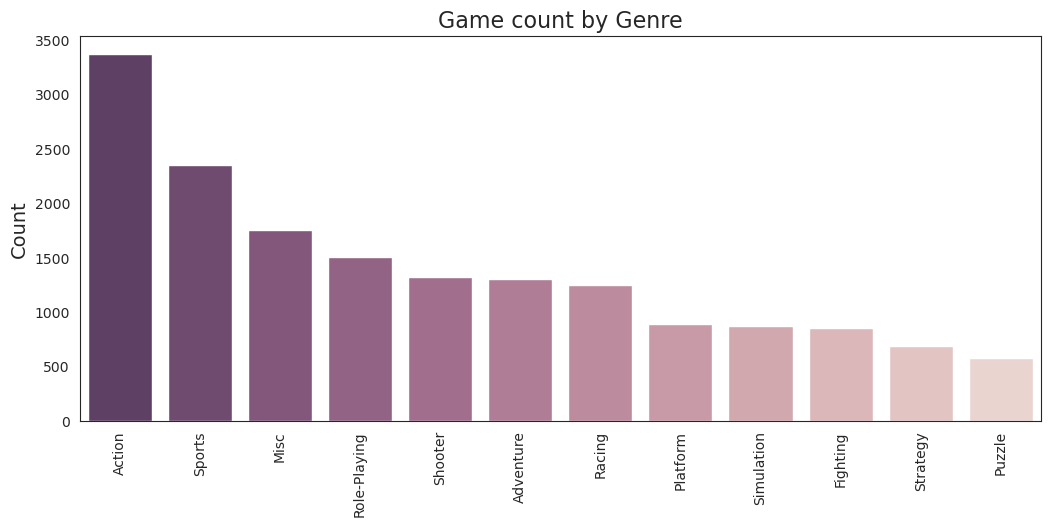

In [4]:
cols = ['Platform', 'Developer', 'Publisher', 'Genre']

for col in cols:
    chart = df[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()
    sns.set_style("white")
    plt.figure(figsize=(12.4, 5))
    plt.xticks(rotation=90)
    sns.barplot(x=col, y='Name', data=chart[:30], palette=sns.cubehelix_palette((12 if col == 'Genre' else 30), dark=0.3, light=.85, reverse=True)).set_title(('Game count by '+col), fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.xlabel('')

Sales vs. critic scores
--------------------------------
**By platform, developer, publisher, and genre.**

In [5]:
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [6]:
dfh = df.dropna(subset=['Critic_Score']).reset_index(drop=True)
dfh['Score_Group'] = dfh['Critic_Score'].apply(lambda x: score_group(x))

In [7]:
def in_top(x):
    if x in pack:
        return x
    else:
        pass
def width(x):
    if x == 'Platform':
        return 14.4
    elif x == 'Developer':
        return 13.2
    elif x == 'Publisher':
        return 11.3
    elif x == 'Genre':
        return 13.6

def height(x):
    if x == 'Genre':
        return 8
    else:
        return 9

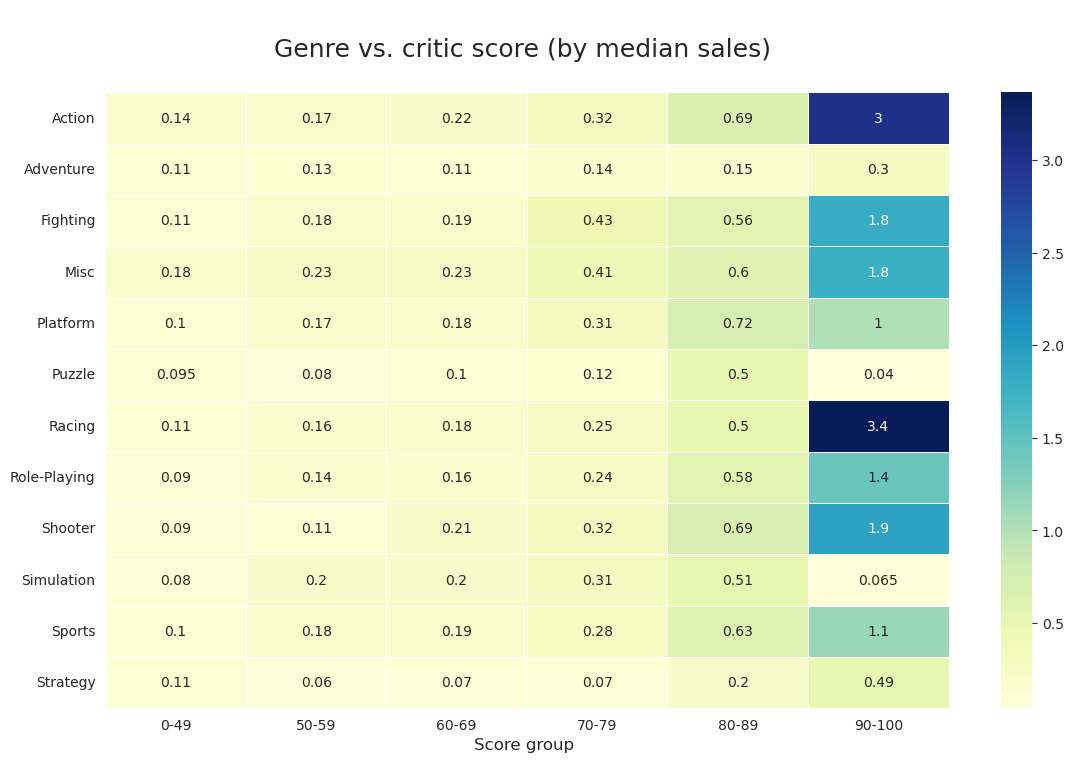

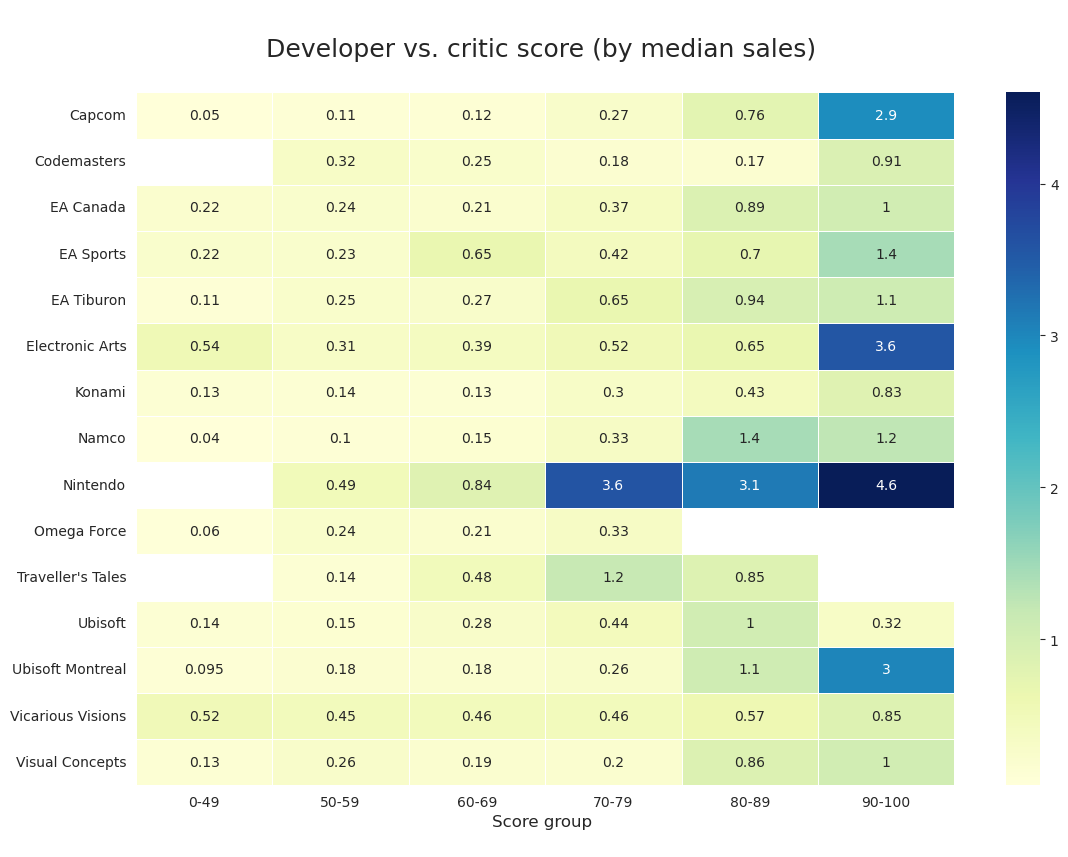

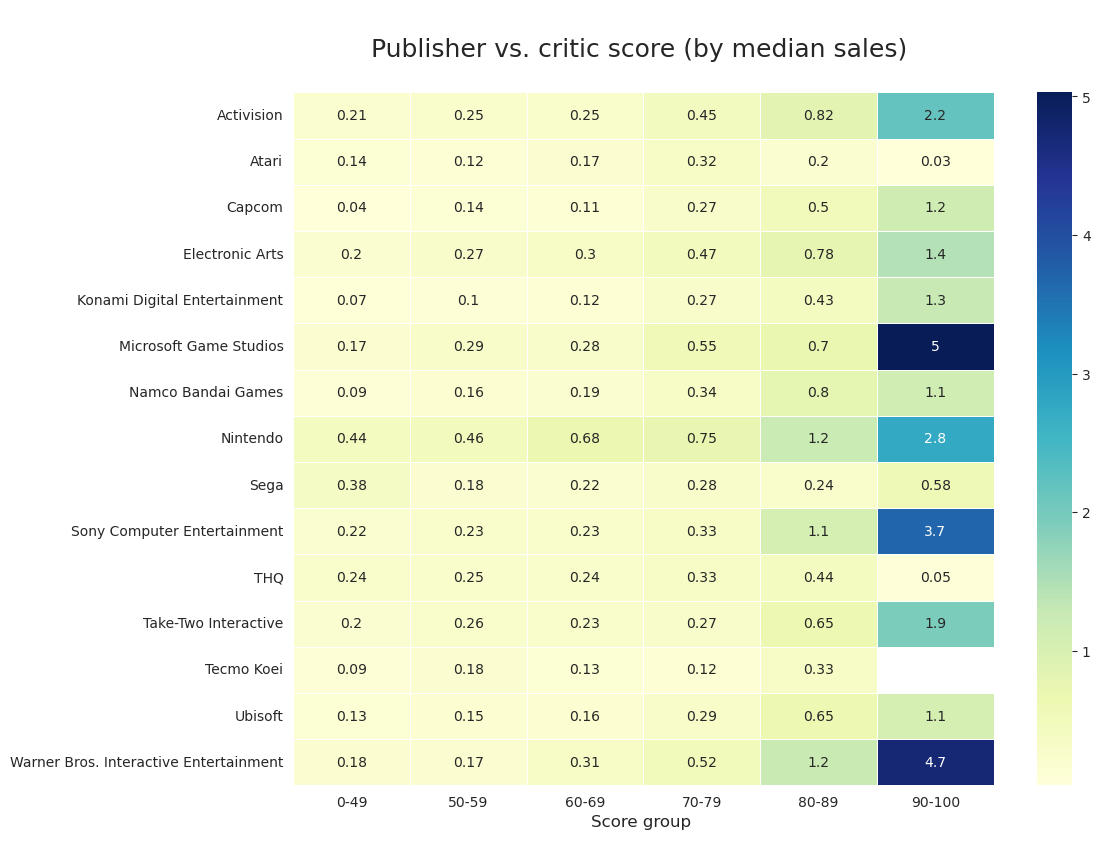

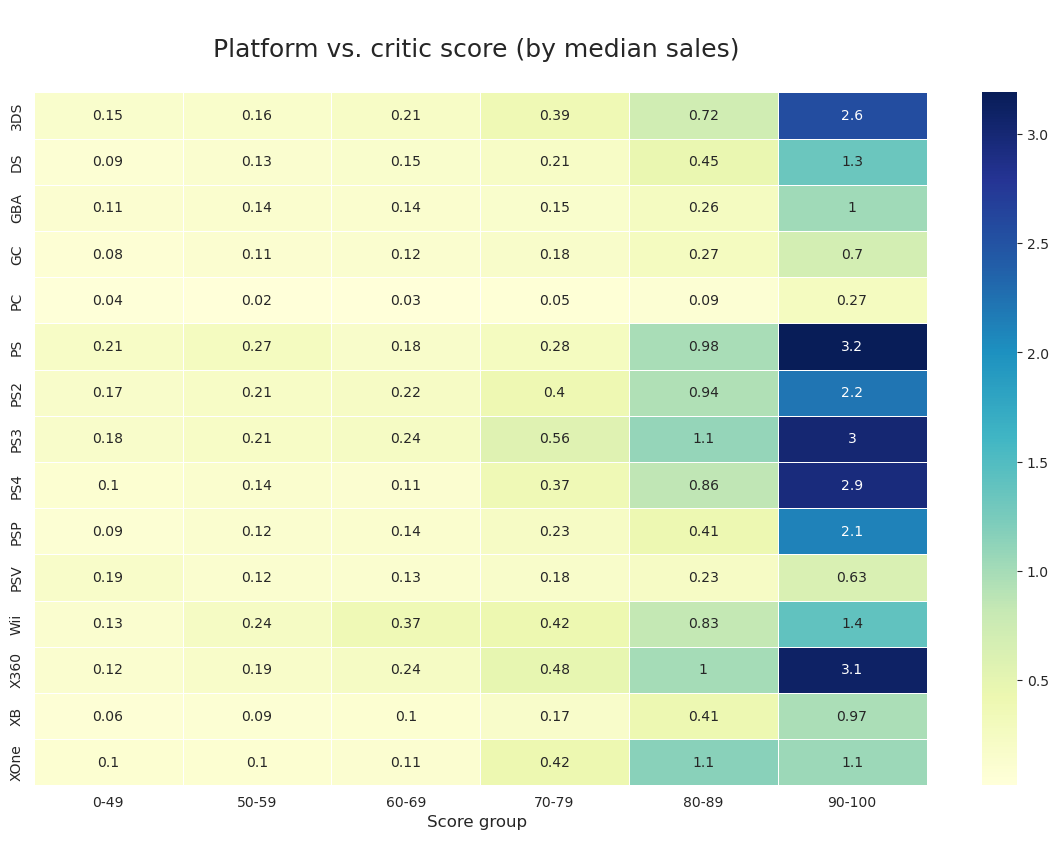

In [8]:
cols = ['Genre', 'Developer', 'Publisher', 'Platform']
for col in cols:
    pack = []
    top = dfh[['Name', col]].groupby([col]).count().sort_values('Name', ascending=False).reset_index()[:15]
    for x in top[col]:
        pack.append(x)
    dfh[col] = dfh[col].apply(lambda x: in_top(x))
    dfh_platform = dfh[[col, 'Score_Group', 'Global_Sales']].groupby([col, 'Score_Group']).median().reset_index().pivot(col, "Score_Group", "Global_Sales")
    plt.figure(figsize=(width(col), height(col)))
    sns.heatmap(dfh_platform, annot=True, fmt=".2g", linewidths=.5, cmap="YlGnBu").set_title((' \n'+col+' vs. critic score (by median sales) \n'), fontsize=18)
    plt.ylabel('', fontsize=14)
    plt.xlabel('Score group \n', fontsize=12)
    pack = []

Dataset correlations
--------------------------------
**Conversion of categorical columns into numeric codes**

In [9]:
cols = ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']
for col in cols:
    uniques = df[col].value_counts().keys()
    uniques_dict = {}
    ct = 0
    for i in uniques:
        uniques_dict[i] = ct
        ct += 1

    for k, v in uniques_dict.items():
        df.loc[df[col] == k, col] = v

In [10]:
df1 = df[['Platform','Genre','Publisher','Year_of_Release','Critic_Score'
          ,'Global_Sales']]
df1 = df1.dropna().reset_index(drop=True)
df1 = df1.astype('float64')

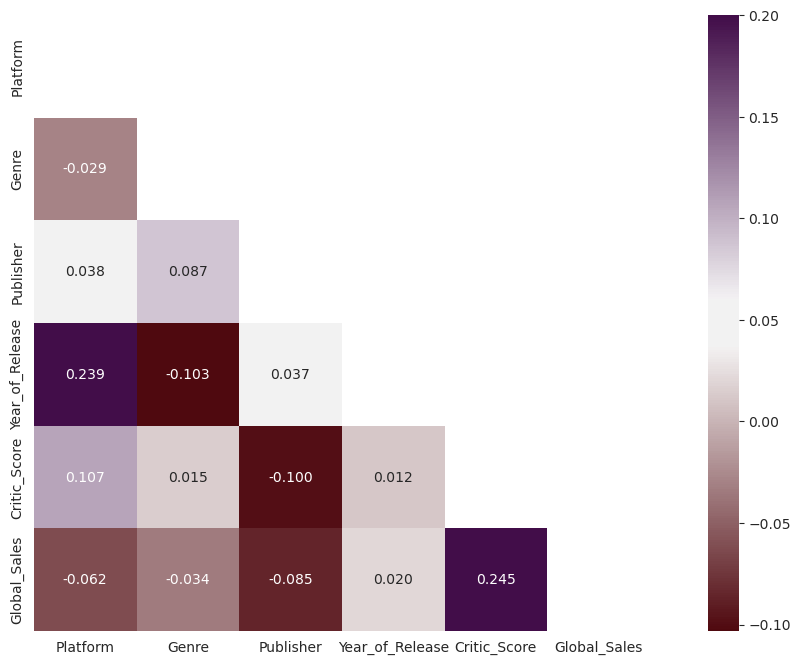

In [11]:
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(730, 300, sep=20, as_cmap=True, s=85, l=15, n=20) # note: 680, 350/470
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1, figsize=(15,8))
    ax = sns.heatmap(df1.corr(), mask=mask, vmax=0.2, square=True, annot=True, fmt=".3f", cmap=cmap)

Critic scores to global sales
-----------------------------

[(0.0, 17.5)]

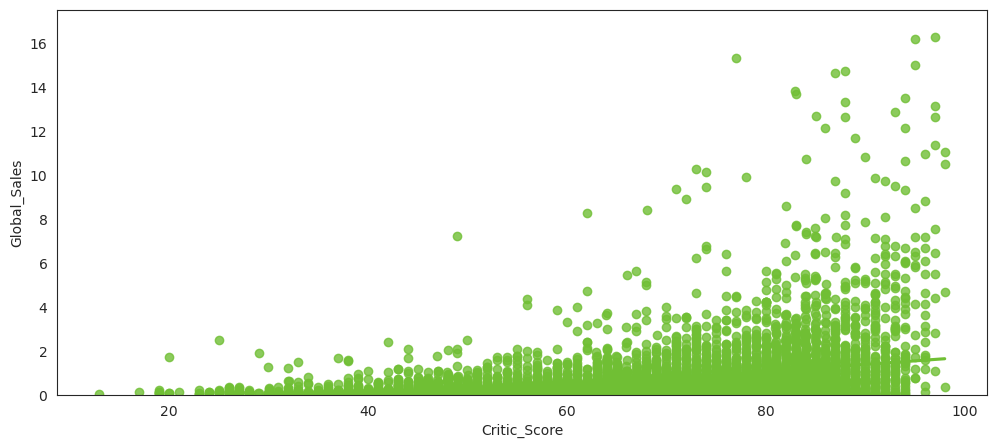

In [12]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1, ci=None, color="#70bf34", x_jitter=.02).set(ylim=(0, 17.5))

**Kinda messy, right?**

**We'll go ahead and use bins to get a better feel for the correlation.**

[(0.0, 4.0), (50.0, 95.0)]

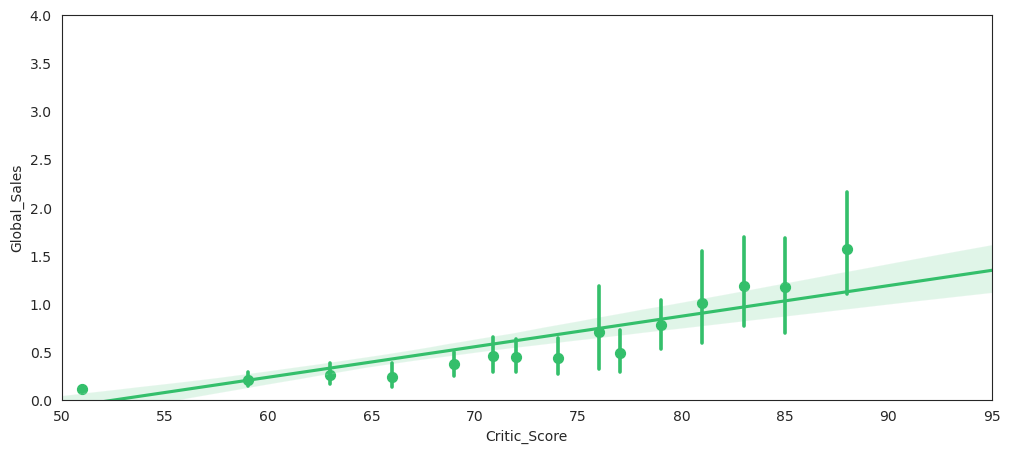

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Global_Sales", data=df1.loc[df1.Year_of_Release >= 2014],
            truncate=True, x_bins=15, color="#34bf6b").set(ylim=(0, 4), xlim=(50, 95))

Let's choose hits which got more than 1 mil sales
---------------------------------------------------------

In [14]:
dfb = dfa[['Name','Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
dfb = dfb.dropna().reset_index(drop=True)
df2 = dfb[['Platform','Genre','Publisher','Year_of_Release','Critic_Score','Global_Sales']]
df2['Hit'] = df2['Global_Sales']
df2.drop('Global_Sales', axis=1, inplace=True)

In [15]:
def hit(sales):
    if sales >= 1:
        return 1
    else:
        return 0

df2['Hit'] = df2['Hit'].apply(lambda x: hit(x))

**Let's graph the relationship between critic scores and VG hits using a 5% sample...** 

<Axes: xlabel='Critic_Score', ylabel='Hit'>

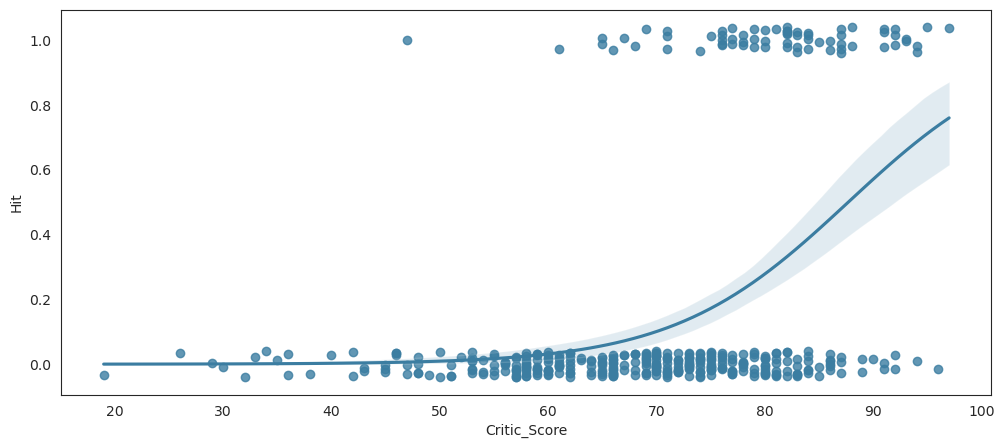

In [16]:
# Logistic regression plot with sample of the data
n = ceil(0.05 * len(df2['Hit']))
fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.regplot(x="Critic_Score", y="Hit", data=df2.sample(n=n),
            logistic=True, n_boot=500, y_jitter=.04, color="#3b7da1")

**As expected, it seems hits are mostly found near high critic scores, while non-hits can vary in scores but don't have as strong of a presence in the high score ranges (as seen in the steepening regression curve near the 70's).**

----------

Prediction model
=============================

Generating features
------------------------------------------------------------------------

In [17]:
df2[:5]

,Platform,Genre,Publisher,Year_of_Release,Critic_Score,Hit
0,Wii,Sports,Nintendo,2006.0,76.0,1
1,Wii,Racing,Nintendo,2008.0,82.0,1
2,Wii,Sports,Nintendo,2009.0,80.0,1
3,DS,Platform,Nintendo,2006.0,89.0,1
4,Wii,Misc,Nintendo,2006.0,58.0,1


In [18]:
df_copy = pd.get_dummies(df2)

In [19]:
df_copy[:5]

,Year_of_Release,Critic_Score,Hit,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Publisher_Xplosiv,Publisher_Xseed Games,Publisher_Yacht Club Games,Publisher_Yuke's,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Publisher_Zushi Games,Publisher_bitComposer Games,Publisher_id Software,Publisher_inXile Entertainment
0,2006.0,76.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2008.0,82.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2009.0,80.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2006.0,89.0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006.0,58.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df3 = df_copy.copy()
y = df3['Hit'].values
df3 = df3.drop(['Hit'],axis=1)
X = df3.values

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y)

https://www.justintodata.com/automl-python-tools/

https://machinelearningmastery.com/automl-libraries-for-python/

# AutoML

## H2O

In [22]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpzpdq840o
  JVM stdout: /tmp/tmpzpdq840o/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpzpdq840o/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,"28 days, 17 hours and 30 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_z4yjix
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.500 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [23]:
df_h20_copy = df_copy.copy()
df_h20_copy['Hit'] = df_h20_copy.Hit.astype('category')

In [24]:
# Run AutoML for 20 base models
aml = H2OAutoML(max_runtime_secs=7_200, verbosity='error') #
train_h,test_h = train_test_split(df_h20_copy, test_size=0.3 )
train_h20 = h2o.H2OFrame(train_h)
train_h20['Hit'] = train_h20["Hit"].asfactor()

test_h20 = h2o.H2OFrame(test_h)
test_h20['Hit'] = test_h20["Hit"].asfactor()

# h2o_frame = h2o.H2OFrame(df_h20_copy)
# h2o_frame['Hit'] = h2o_frame["Hit"].asfactor()

x = train_h20.columns
yy = "Hit"
x.remove(yy)
aml.train(x=x, y=yy, training_frame=train_h20)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_Best1000_1_AutoML_1_20230719_111906,0.871939,0.301708,0.626047,0.224105,0.302781,0.0916761
StackedEnsemble_BestOfFamily_7_AutoML_1_20230719_111906,0.871627,0.301861,0.626128,0.221602,0.302735,0.0916486
StackedEnsemble_AllModels_4_AutoML_1_20230719_111906,0.870881,0.30256,0.624503,0.229503,0.303026,0.0918247
StackedEnsemble_BestOfFamily_4_AutoML_1_20230719_111906,0.870842,0.302845,0.62199,0.23454,0.303394,0.0920478
StackedEnsemble_AllModels_3_AutoML_1_20230719_111906,0.87075,0.303048,0.622623,0.223094,0.303455,0.0920851
StackedEnsemble_BestOfFamily_5_AutoML_1_20230719_111906,0.87048,0.302839,0.623854,0.24173,0.303247,0.0919585
StackedEnsemble_AllModels_6_AutoML_1_20230719_111906,0.870385,0.302996,0.625115,0.23454,0.302993,0.0918047
StackedEnsemble_AllModels_2_AutoML_1_20230719_111906,0.868131,0.30461,0.621263,0.235528,0.304148,0.0925061
StackedEnsemble_BestOfFamily_3_AutoML_1_20230719_111906,0.868029,0.304378,0.622515,0.245887,0.303895,0.0923525
XGBoost_lr_search_selection_AutoML_1_20230719_111906_select_grid_model_2,0.867991,0.30587,0.616259,0.232411,0.305118,0.0930969


In [25]:
leader_model = aml.leader

In [26]:
aml.event_log

timestamp,level,stage,message,name,value
11:19:06.748,INFO,Workflow,Project: AutoML_1_20230719_111906,,
11:19:06.752,INFO,Validation,5-fold cross-validation will be used.,,
11:19:06.763,INFO,Validation,Setting stopping tolerance adaptively based on the training frame: 0.013378599850276613,,
11:19:06.764,INFO,Validation,Build control seed: -1 (random),,
11:19:06.766,INFO,DataImport,training frame: Frame key: AutoML_1_20230719_111906_training_py_1_sid_9244 cols: 334 rows: 5587 chunks: 2 size: 93176 checksum: -3466932047462561546,,
11:19:06.766,INFO,DataImport,validation frame: NULL,,
11:19:06.767,INFO,DataImport,leaderboard frame: NULL,,
11:19:06.767,INFO,DataImport,blending frame: NULL,,
11:19:06.767,INFO,DataImport,response column: Hit,,
11:19:06.767,INFO,DataImport,fold column: null,,


In [27]:
aml.training_info

{'creation_epoch': '1689765547',
 'start_epoch': '1689765547',
 'start_XGBoost_def_2': '1689765547',
 'start_GLM_def_1': '1689765563',
 'start_GBM_def_5': '1689765571',
 'start_StackedEnsemble_best_of_family_1': '1689765599',
 'start_XGBoost_def_1': '1689765600',
 'start_DRF_def_1': '1689765607',
 'start_GBM_def_2': '1689765620',
 'start_GBM_def_3': '1689765636',
 'start_GBM_def_4': '1689765653',
 'start_StackedEnsemble_best_of_family_2': '1689765671',
 'start_StackedEnsemble_all_2': '1689765672',
 'start_XGBoost_def_3': '1689765673',
 'start_DRF_XRT': '1689765680',
 'start_GBM_def_1': '1689765684',
 'start_DeepLearning_def_1': '1689765697',
 'start_StackedEnsemble_best_of_family_3': '1689765709',
 'start_StackedEnsemble_all_3': '1689765710',
 'start_XGBoost_grid_1': '1689765711',
 'start_GBM_grid_1': '1689766650',
 'start_DeepLearning_grid_1': '1689767016',
 'start_StackedEnsemble_best_of_family_4': '1689770840',
 'start_StackedEnsemble_all_4': '1689770842',
 'start_DeepLearning_grid_

In [28]:
leader_model.predict(test_h20)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.820847,0.179153
0,0.956097,0.0439034
0,0.858581,0.141419
1,0.0688347,0.931165
0,0.943999,0.0560008
1,0.490334,0.509666
0,0.790874,0.209126
1,0.237418,0.762582
0,0.966406,0.0335938
0,0.974482,0.025518


In [29]:
y_val_h = leader_model.predict(test_h20)['predict'].as_data_frame(use_pandas=True).squeeze()
print("Validation accuracy: ", sum(y_val_h.values
                                   == ytest)/len(ytest))

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Validation accuracy:  0.6931106471816284


## TPOT

In [30]:
!pip install tpot -q

In [31]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, stratify=y)

In [32]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold
from tpot import TPOTClassifier

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
tpot_model = TPOTClassifier(max_time_mins=240,
                            #generations=1, 
                            population_size=120, scoring='neg_mean_absolute_error', cv=cv,
                            verbosity=2, use_dask = False,n_jobs=1,
                            early_stop=15, max_eval_time_mins=10  )
tpot_model.fit(Xtrain, ytrain)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


240.65 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=8, max_features=0.1, min_samples_leaf=20, min_samples_split=4, n_estimators=100, subsample=0.8)


TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
               early_stop=15, max_eval_time_mins=10, max_time_mins=240,
               population_size=120, scoring='neg_mean_absolute_error',
               verbosity=2)

In [33]:
tpot_model.export('tpot_insurance_best_model.py')

Optimizing Hyperparameters
-------------------------------------------

In [34]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

radm = RandomForestClassifier()
kf = KFold(n_splits=10,shuffle=True)
radm_params = {
                "n_estimators" : np.arange(100,5000,5),
                "criterion": ["gini", "entropy"],
                "max_depth": np.arange(1,15,1),
                "max_features": ["sqrt", "log2", None, "auto"], #
                "n_jobs": [-1],

                }

radm_cv = RandomizedSearchCV(radm,
                     radm_params,
                     cv=kf,                                  
                     n_jobs=-1,
                     verbose=-1, n_iter=1).fit(Xtrain, ytrain) # You can play with timeout parameter in any way you want

radm = RandomForestClassifier(**radm_cv.best_params_).fit(Xtrain, ytrain)
gc.collect()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


CPU times: user 39.6 s, sys: 3.79 s, total: 43.4 s
Wall time: 1min 39s


2802

In [35]:
y_val_1 = radm.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_1).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.8317327766179541


In [36]:
%%time

log_reg = LogisticRegression()
kf = KFold(n_splits=10,shuffle=True)
log_params = {
        'solver' : ['newton-cg',"lbfgs","saga","sag"],
        'tol': np.arange(1e-7, 3.0, 0.000001),
        'C': np.arange( 1, 12.0, 0.00002),
        'fit_intercept': [True,False],
        'max_iter': np.arange( 1000, 10000,100),
        'n_jobs':[-1],   

                }
log_cv = RandomizedSearchCV(log_reg,
                     log_params,
                     cv=kf,                                  
                     n_jobs=-1,
                     verbose=-1, n_iter=1_500).fit(Xtrain, ytrain) # You can play with timeout parameter in any way you want

log_reg = LogisticRegression(**log_cv.best_params_).fit(Xtrain, ytrain)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorith

CPU times: user 42.8 s, sys: 4.1 s, total: 46.9 s
Wall time: 1h 50min 45s


In [37]:
y_val_2 = log_reg.predict_proba(Xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_2).idxmax(axis=1).values
                                   == ytest)/len(ytest))

Validation accuracy:  0.8617954070981211


In [38]:
all_predictions = log_reg.predict(Xtest)
print(classification_report(ytest, all_predictions))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1992
           1       0.65      0.38      0.48       403

    accuracy                           0.86      2395
   macro avg       0.77      0.67      0.70      2395
weighted avg       0.85      0.86      0.85      2395



Text(0.5, 1.0, 'Predicted and Expected')

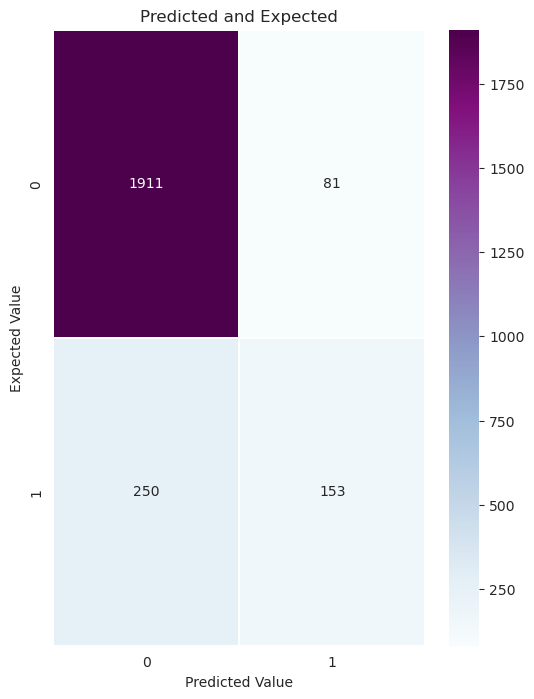

In [39]:
fig, ax = plt.subplots(figsize=(6,8))
sns.heatmap(confusion_matrix(ytest, all_predictions), annot=True, linewidths=.10, ax=ax, fmt="d", cbar=True, cmap="BuPu").set(xlabel='Predicted Value', ylabel='Expected Value')
ax.set_title('Predicted and Expected')

Ranking features performance
---------------------------

In [40]:
indices = np.argsort(radm.feature_importances_)[::-1]

# Print the feature ranking
print('Feature ranking (top 10):')

for f in range(10):
    print('%d. feature %d %s (%f)' % (f+1 , indices[f], df3.columns[indices[f]],
                                      radm.feature_importances_[indices[f]]))

Feature ranking (top 10):
1. feature 1 Critic_Score (0.183565)
2. feature 216 Publisher_Nintendo (0.097662)
3. feature 99 Publisher_Electronic Arts (0.069987)
4. feature 0 Year_of_Release (0.058085)
5. feature 10 Platform_PS3 (0.049818)
6. feature 7 Platform_PC (0.041040)
7. feature 17 Platform_XB (0.040022)
8. feature 289 Publisher_Take-Two Interactive (0.031206)
9. feature 16 Platform_X360 (0.026452)
10. feature 272 Publisher_SquareSoft (0.024755)


In [41]:
not_hit_copy = df_copy[df_copy['Hit'] == 0]

In [42]:
df4 = not_hit_copy.copy()
y = df4['Hit'].values
df4 = df4.drop(['Hit'],axis=1)
X = df4.values

In [43]:
tpot_model.predict_proba

<bound method TPOTBase.predict_proba of TPOTClassifier(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=10, random_state=None),
               early_stop=15, max_eval_time_mins=10, max_time_mins=240,
               population_size=120, scoring='neg_mean_absolute_error',
               verbosity=2)>

In [44]:
pred_topt = np.array(tpot_model.predict_proba(X))
pred_topt.shape

(6640, 2)

In [45]:
pred_h20=np.array(leader_model.predict(h2o.H2OFrame(df4)).as_data_frame()[['p0', 'p1']])
pred_h20.shape

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


(6640, 2)

In [46]:
X.shape

(6640, 333)

In [47]:
pred = log_reg.predict_proba(X)
print(pred.shape)
pred

(6640, 2)


array([[8.83689407e-01, 1.16310593e-01],
       [6.30782670e-01, 3.69217330e-01],
       [6.18690249e-01, 3.81309751e-01],
       ...,
       [9.97090270e-01, 2.90972996e-03],
       [9.99095957e-01, 9.04043231e-04],
       [9.96640476e-01, 3.35952419e-03]])

In [48]:
dfb = dfb[dfb['Global_Sales'] < 1]

In [49]:
dfb['Hit_Probability'] = pred[:,1]

In [50]:
dfb['Hit_Probability_h20'] = pred_h20[:,1]

In [51]:
dfb['Hit_Probability_topt'] = pred_topt[:,1]

In [52]:
df_temp = dfb[dfb['Year_of_Release'] == 2014]
df_temp.sort_values(['Hit_Probability'], ascending=[False], inplace=True)
dfb_end = df_temp.copy(deep=True)

Top 10 games from 2010 with *highest* probability of becoming hits:
---------------

In [53]:
dfb_end[['Name', 'Platform', 'Hit_Probability']][:10]

,Name,Platform,Hit_Probability
1746,Bayonetta 2,WiiU,0.785506
3290,Rayman Legends,XOne,0.645211
1435,Dragon Age: Inquisition,XOne,0.565132
2894,Story of Seasons,3DS,0.555866
2772,Skylanders: Trap Team,PS4,0.553440
2115,Plants vs. Zombies: Garden Warfare,PS4,0.550684
2126,Borderlands: The Pre-Sequel,PS3,0.540759
1462,South Park: The Stick of Truth,PS3,0.514475
1451,The LEGO Movie Videogame,PS3,0.504931
2584,Pokemon Art Academy,3DS,0.503801


Top 10 games from 2010 with *lowest* probability of becoming hits:
---------------

In [54]:
dfb_end[['Name', 'Platform', 'Hit_Probability']][:-11:-1]

,Name,Platform,Hit_Probability
7689,Tenkai Knights: Brave Battle,3DS,0.000619
6199,How to Train Your Dragon 2,WiiU,0.001211
3488,Sonic Boom: Rise of Lyric,WiiU,0.001388
5946,F1 2014,PC,0.002406
6455,Escape Dead Island,X360,0.003176
7393,Power Rangers Super Megaforce,3DS,0.003219
4666,Corpse Party: Blood Drive,PSV,0.003347
7228,Castlevania: Lords of Shadow 2,PC,0.003433
7655,Sacred 3,PC,0.003940
6565,Natural Doctrine,PSV,0.004115


## for h20

In [55]:
df_temp = dfb[dfb['Year_of_Release'] == 2014]
df_temp.sort_values(['Hit_Probability_h20'], ascending=[False], inplace=True)
dfb_end = df_temp.copy(deep=True)

In [56]:
dfb_end[['Name', 'Platform', 'Hit_Probability_h20']][:10]

,Name,Platform,Hit_Probability_h20
2115,Plants vs. Zombies: Garden Warfare,PS4,0.693164
1944,Wolfenstein: The New Order,XOne,0.678005
1746,Bayonetta 2,WiiU,0.665753
1435,Dragon Age: Inquisition,XOne,0.602523
1451,The LEGO Movie Videogame,PS3,0.598003
2879,Trials Fusion,PS4,0.574053
1919,Plants vs. Zombies: Garden Warfare,XOne,0.532589
6970,Child of Light,PS4,0.512264
1788,Dark Souls II,X360,0.456224
1447,Lego Batman 3: Beyond Gotham,PS4,0.440229


In [57]:
dfb_end[['Name', 'Platform', 'Hit_Probability_h20']][:-11:-1]

,Name,Platform,Hit_Probability_h20
6199,How to Train Your Dragon 2,WiiU,0.001016
4666,Corpse Party: Blood Drive,PSV,0.001192
6565,Natural Doctrine,PSV,0.001279
7881,htoL#NiQ: The Firefly Diary,PSV,0.001708
6481,Tokyo Twilight Ghost Hunters,PSV,0.001733
5960,Operation Abyss: New Tokyo Legacy,PSV,0.001792
5406,Hyperdevotion Noire: Goddess Black Heart,PSV,0.001964
6307,Lost Dimension,PSV,0.002516
6647,A-Train: City Simulator,3DS,0.002675
5385,Deception IV: Blood Ties,PSV,0.003118


## For TOPT

In [58]:
df_temp = dfb[dfb['Year_of_Release'] == 2014]
df_temp.sort_values(['Hit_Probability_topt'], ascending=[False], inplace=True)
dfb_end = df_temp.copy(deep=True)

In [59]:
dfb_end[['Name', 'Platform', 'Hit_Probability_topt']][:10]

,Name,Platform,Hit_Probability_topt
3290,Rayman Legends,XOne,0.727055
1462,South Park: The Stick of Truth,PS3,0.684940
1746,Bayonetta 2,WiiU,0.684620
1788,Dark Souls II,X360,0.667410
2115,Plants vs. Zombies: Garden Warfare,PS4,0.647137
1435,Dragon Age: Inquisition,XOne,0.615082
1451,The LEGO Movie Videogame,PS3,0.533995
6547,Terraria,PS4,0.484671
1842,MLB 14: The Show,PS4,0.471217
6970,Child of Light,PS4,0.440210


In [60]:
dfb_end[['Name', 'Platform', 'Hit_Probability_topt']][:-11:-1]

,Name,Platform,Hit_Probability_topt
6199,How to Train Your Dragon 2,WiiU,0.005099
6565,Natural Doctrine,PSV,0.005614
5960,Operation Abyss: New Tokyo Legacy,PSV,0.007240
7881,htoL#NiQ: The Firefly Diary,PSV,0.007871
7228,Castlevania: Lords of Shadow 2,PC,0.007872
3488,Sonic Boom: Rise of Lyric,WiiU,0.008114
5946,F1 2014,PC,0.008154
4666,Corpse Party: Blood Drive,PSV,0.008947
6307,Lost Dimension,PSV,0.009852
7655,Sacred 3,PC,0.010245
